In [1]:
%matplotlib inline
import pylab as plt
import numpy as np
from collections import Counter
import fitsio
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8,6)
import sys
sys.path.append('legacypipe/py')

In [2]:
#!module load gcc; cd tractor; export "TSNNLS_INC=$HOME/software/libtsnnls/include"; export "TSNNLS_LIB=-L$HOME/software/libtsnnls/lib -ltsnnls"; python setup.py --with-tsnnls build_ext --inplace

In [3]:
!module load gcc; cd tractor; \
export TSNNLS_INC="$HOME/software/libtsnnls/include"; \
export TSNNLS_LIB="$HOME/software/libtsnnls/lib"; \
python setup.py --with-tsnnls build_ext --inplace

Package eigen3 was not found in the pkg-config search path.
Perhaps you should add the directory containing `eigen3.pc'
to the PKG_CONFIG_PATH environment variable
No package 'eigen3' found
echo "version = '$(git describe)'" > tractor/version.py
running build_ext


In [5]:
sys.path.insert(0, 'tractor')
import tractor
print(tractor.__file__)
from tractor.tsnnls import *

tractor/tractor/__init__.py


In [6]:
# Grab a single DECam exposure near this RA,Dec.
ra,dec = 129.6003, 25.7545
W,H = 200,200

In [7]:
from legacypipe.survey import BrickDuck, wcs_for_brick, LegacySurveyData
survey = LegacySurveyData('cosmo/work/users/dstn/dr9/south')
# Custom brick; create a fake 'brick' object
brickname = 'custom'
brick = BrickDuck(ra, dec, brickname)
targetwcs = wcs_for_brick(brick, W=W, H=H)
ccds = survey.ccds_touching_wcs(targetwcs, ccdrad=None)
len(ccds)

16

In [8]:
ccds.expnum

array([431506, 431507, 829480, 433110, 801602, 392438, 393589, 392443,
       801263, 801264, 392436, 392433, 393586, 731060, 510577, 731069])

In [9]:
#CCD decam g 801602 S1, 175.0 sec
ccds.cut(ccds.expnum == 801602)

In [10]:
im = survey.get_image_object(ccds[0])
im

c4d_181210_073247_ooi_g_ls9-S1

In [11]:
targetrd = np.array([targetwcs.pixelxy2radec(x,y) for x,y in
                    [(1,1),(W,1),(W,H),(1,H),(1,1)]])
tim = im.get_tractor_image(radecpoly=targetrd)

Reading cosmo/work/users/dstn/dr9/south/images/decam/CP/V4.9/CP20181209/c4d_181210_073247_ooi_g_ls9.fits.fz ext 25


DECALS_DR9_981acdd-g-20181210T073247_oi[S1,noinherit][2046,4094][real]: DECaLS_1 [astropy.io.fits.card]
legacypipe/py/legacypipe/image.py:742: UserWarning: image median is 4.30 sigma away from zero!
  warnings.warn('image median is %.2f sigma away from zero!' % (imgmed / self.sig1))


In [12]:
tim.shape

(202, 202)

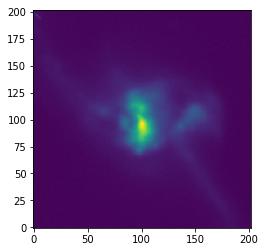

In [13]:
plt.imshow(tim.getImage(), origin='lower', interpolation='nearest');

In [14]:
psf = tim.getPsf()
psfimg = psf.constantPsfAt(W//2, H//2).pix.getImage(0, 0)
psfimg /= psfimg.sum()

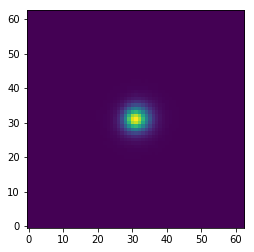

In [15]:
plt.imshow(psfimg, interpolation='nearest', origin='lower');

In [16]:
# Estimate per-pixel noise in PSF model
slice1 = (slice(0,-5,10),slice(0,-5,10))
slice2 = (slice(5,None,10),slice(5,None,10))
mad = np.median(np.abs(psfimg[slice1] - psfimg[slice2]).ravel())
sig1 = 1.4826 * mad / np.sqrt(2.)
sig1

2.788276084627815e-06

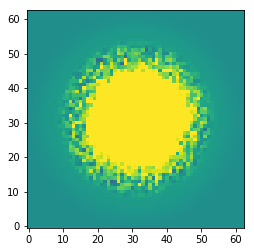

In [17]:
plt.imshow(psfimg, interpolation='nearest', origin='lower', vmin=-10*sig1, vmax=10*sig1);

In [18]:
# These PSF models have been modified -- they have a smooth stellar halo inserted for the outskirts.

In [19]:
# Define the 'ideal' PSF we want to use to represent the model image.
ph,pw = psfimg.shape
xx,yy = np.meshgrid(np.arange(pw), np.arange(ph))
#psfsigma = 1.2
psfsigma = 1.5
ideal_psf = np.exp(-0.5 * ((xx - pw//2)**2 + (yy - ph//2)**2) / (psfsigma**2))
ideal_psf /= np.sum(ideal_psf)

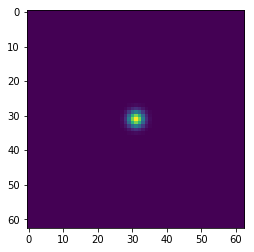

In [20]:
plt.imshow(ideal_psf, interpolation='nearest');

In [21]:
# let's get Fourier
Fimg = np.fft.fft2(psfimg)
Fideal = np.fft.fft2(ideal_psf)

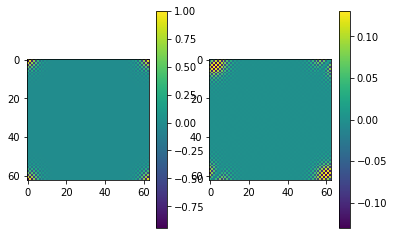

In [22]:
plt.subplot(1,2,1)
plt.imshow(Fimg.real)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(Fimg.imag);
plt.colorbar();

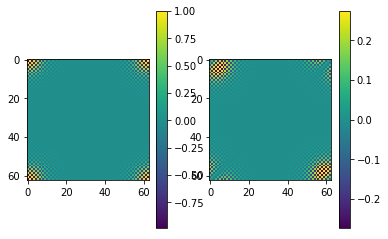

In [23]:
plt.subplot(1,2,1)
plt.imshow(Fideal.real)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(Fideal.imag);
plt.colorbar();

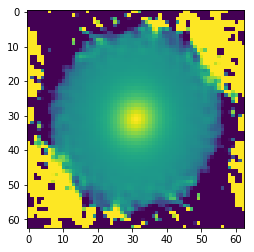

In [24]:
# Straight-up deconvolution is bad
Fmatch = Fimg / Fideal
plt.imshow(np.fft.fftshift(Fmatch).real, vmin=-1, vmax=1);

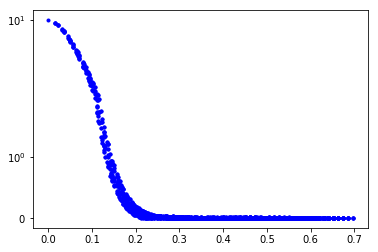

In [25]:
# PSF Fourier amplitude
freqs = np.fft.fftfreq(pw)
freq2 = np.hypot(freqs[:,np.newaxis], freqs[np.newaxis,:])
plt.plot(freq2.ravel(), 10*np.abs(Fimg.real.ravel()), 'b.');
plt.yscale('symlog', linthresh=1e-3)

In [26]:
if False:
    nbins = 50
    fbin = np.clip((nbins * freq2 / 0.5).astype(int), 0, nbins-1)
    sbin = np.zeros(nbins)
    for i in range(nbins):
        I = np.flatnonzero(fbin == i)
        if len(I) == 0:
            continue
        sbin[i] = np.mean(Fimg.real.flat[I] ** 2)
    S = sbin[fbin]
    N = 0.1**2

In [27]:
#G = 1. / Fideal * (1. / (1. + 1. / (np.abs(Fideal)**2 * (np.abs(Fimg.real) / 0.1))))
#G = 1. / Fideal * (1. / (1. + 1. / (np.abs(Fideal)**2 * (S / N))))

# Wiener filter with constant S/N ratio
SNR = 100.
G = 1. / Fideal * (1. / (1. + 1. / (np.abs(Fideal)**2 * SNR)))
# Fourier transform of ideal -> image matching PSF convolution
Wmatch = G * Fimg

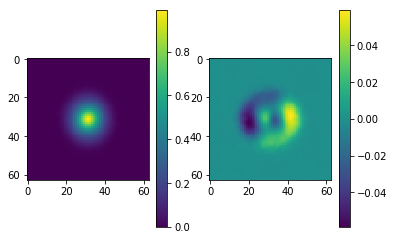

In [28]:
plt.subplot(1,2,1)
plt.imshow(np.fft.fftshift(Wmatch).real, interpolation='nearest')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(np.fft.fftshift(Wmatch).imag)
plt.colorbar();

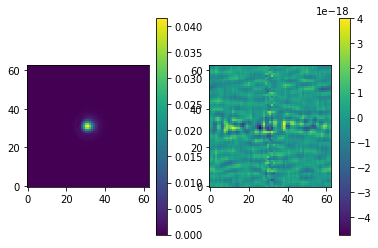

In [29]:
# In real space...
wmatch = np.fft.ifft2(Wmatch)
plt.subplot(1,2,1)
plt.imshow(np.fft.fftshift(wmatch.real), interpolation='nearest', origin='lower');
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(np.fft.fftshift(wmatch.imag), interpolation='nearest', origin='lower');
plt.colorbar();

In [30]:
psfmatch = np.fft.fftshift(wmatch.real)

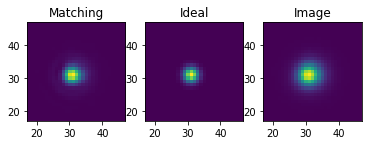

In [31]:
axpsf = [32-15, 32+15, 32-15, 32+15]
plt.subplot(1,3,1)
plt.imshow(psfmatch);
plt.axis(axpsf)
plt.title('Matching')
plt.subplot(1,3,2)
plt.imshow(ideal_psf);
plt.title('Ideal')
plt.axis(axpsf);
plt.subplot(1,3,3)
plt.imshow(psfimg);
plt.title('Image')
plt.axis(axpsf);

In [32]:
Fpsfmatch = np.fft.fft2(psfmatch)
matched = np.fft.ifftshift(np.fft.ifft2(Fpsfmatch * Fideal)).real
matched /= np.sum(matched)

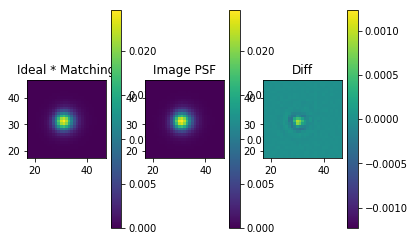

In [33]:
plt.subplot(1,3,1)
mx = matched.max()
plt.imshow(matched.real, vmin=0, vmax=mx);
plt.title('Ideal * Matching')
plt.axis(axpsf);
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(psfimg, vmin=0, vmax=mx);
plt.title('Image PSF')
plt.colorbar()
plt.axis(axpsf);
plt.subplot(1,3,3)
f = 0.05
plt.imshow(psfimg - matched.real, vmin=-f*mx, vmax=f*mx);
plt.title('Diff')
plt.colorbar()
plt.axis(axpsf);

In [34]:
if False:
    th,tw = tim.shape
    twcs = tim.getWcs()
    subwcs = twcs.wcs.get_subimage(int(twcs.x0), int(twcs.y0), int(tw), int(th))

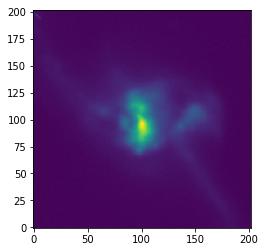

In [35]:
plt.imshow(tim.getImage(), origin='lower', interpolation='nearest');

In [36]:
# Grab a subimage
img = tim.getImage()

img = img[50:, 50:]
img = img[:100, :100]

iW,iH = img.shape

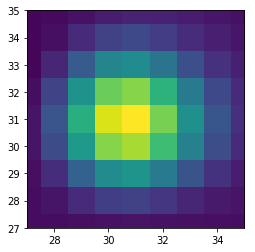

In [37]:
# Grab a subimage of the PSF-matching kernel too
plt.imshow(psfmatch)#, vmin=0, vmax=0.05);
#S = 9
S = 4
subax = [31 - S, 31 + S]*2
plt.axis(subax);
submatch = psfmatch[subax[0]:subax[1]+1, subax[0]:subax[1]+1]

In [38]:
submatch.shape
mh,mw = submatch.shape

In [39]:
# To avoid edge issues, infer an output matrix that is half the kernel size larger than the target image.
margin = mh//2
oW,oH = iW+2*margin, iH+2*margin

In [40]:
# In the ravelled image, compute index offsets of the kernel elements
cx = np.arange(mw)[np.newaxis,:]
cy = np.arange(mh)[:,np.newaxis]
conv_offsets = ((cx - margin) + oW*(cy - margin)).ravel()
conv_offsets
conv_vals = submatch.ravel()
Nconv = len(conv_vals)
Nconv

81

In [41]:
oimg = np.zeros((oH,oW))
oimg[margin:-margin, margin:-margin] = img

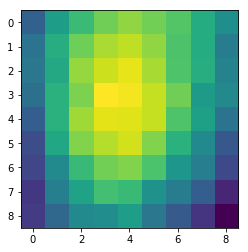

In [42]:
#plt.imshow(oimg.ravel()[oH*105 + 110 + conv_offsets].reshape((mh,mw)));
plt.imshow(oimg.ravel()[oH*50 + 55 + conv_offsets].reshape((mh,mw)));

In [43]:
# Construct the sparse matching-kernel convolution array
spcols = []
sprows = []
spvals = []
for imy in range(iH):
    outy = imy + margin
    for imx in range(iW):
        outx = imx + margin
        sprow = imy * iW + imx
        spcol = outy * oW + outx + conv_offsets
        spcols.append(spcol)
        spvals.append(conv_vals)
        sprows.append([sprow]*Nconv)
spcols = np.hstack(spcols)
sprows = np.hstack(sprows)
spvals = np.hstack(spvals)

In [44]:
import scipy
import scipy.sparse
import scipy.sparse.linalg

In [45]:
# Construct sparse matrix
A = scipy.sparse.csr_matrix((spvals, (sprows, spcols)), shape=(iW*iH, oW*oH))
B = img.ravel()

In [46]:
A.shape, B.shape

((10000, 11664), (10000,))

In [47]:
# Initialization via Wiener filter?
G2 = 1. / Wmatch * (1. / (1. + 1. / (np.abs(Wmatch)**2 * 100.)))
Fimg = np.fft.fft2(oimg)
G2pad = np.zeros_like(Fimg)
gw,gh = G2.shape
G2pad[:gh//2, :gw//2] = G2[:gh//2, :gw//2]
G2pad[-gh//2:, :gw//2] = G2[-gh//2:, :gw//2]
G2pad[:gh//2,  -gw//2:] = G2[:gh//2,  -gw//2:]
G2pad[-gh//2:, -gw//2:] = G2[-gh//2:, -gw//2:]
D = np.fft.ifft2(G2pad * Fimg)

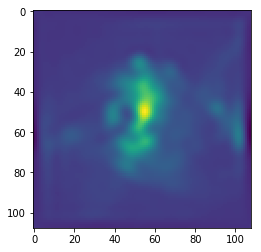

In [48]:
from scipy.ndimage.filters import gaussian_filter
plt.imshow(gaussian_filter(D.real, psfsigma));

In [49]:
X0 = D.real.ravel()
len(X0)

11664

In [50]:
R0 = scipy.sparse.linalg.lsqr(A, B, x0=X0)

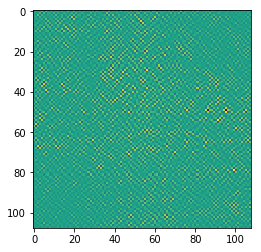

In [51]:
# Straight least-squares -- massive overfitting!!
X = R0[0].reshape((oH,oW))
plt.imshow(X);

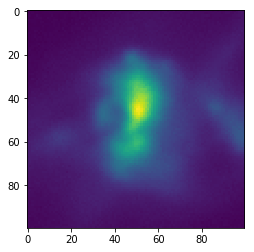

In [52]:
# But it does reconstruct the image...
B0 = (A * R0[0]).reshape((iH,iW))
plt.imshow(B0);

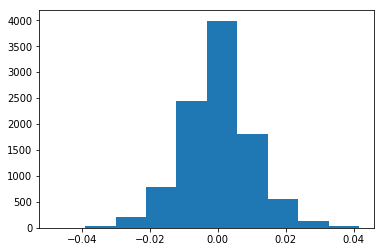

In [53]:
# To a fraction of a per-image-pixel noise sigma!
plt.hist((img - B0).ravel() / tim.sig1);

In [54]:
# Can regularize using L1 "damping":
R1 = scipy.sparse.linalg.lsqr(A, B, x0=X0, damp=0.1)
# (this also runs an order of magnitude faster)

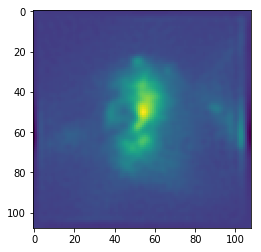

In [55]:
# Here's the model image
X1 = R1[0]
X1 = X1.reshape((oH,oW))
plt.imshow(X1);

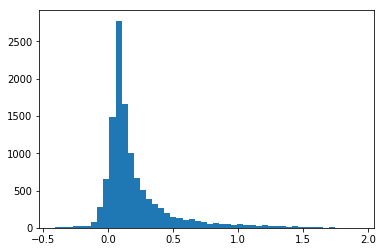

In [56]:
# It does have negative pixels, however.
plt.hist(X1.ravel(), bins=50);

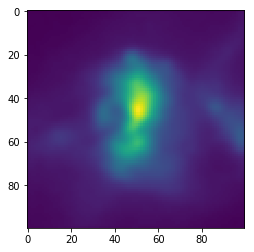

In [57]:
# And the reconstruction:
B1 = (A * X1.ravel()).reshape((iH,iW))
plt.imshow(B1);

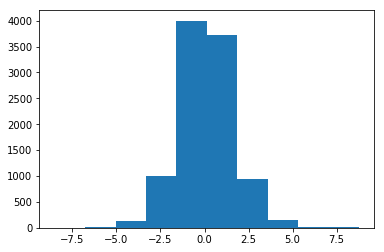

In [58]:
# The reconstruction error is much closer to the image noise distribution!
plt.hist((img - B1).ravel() / tim.sig1);

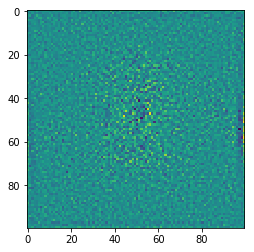

In [60]:
# Reconstruction residuals
plt.imshow((img - B1));

In [57]:
# Make dense array!
AA = A.toarray()

if False:
    AA.shape # (10000, 11664)
    import fitsio
    fitsio.write('aa.fits', AA)

In [58]:
import scipy.optimize

In [59]:
# In theory, we could do this..... but it is too slow!
#RN = scipy.optimize.nnls(AA, B)

In [65]:
# Set up for using tsnnls() routine, which uses a column-oriented sparse matrix representation

# In the ravelled image, compute index offsets of the kernel elements
ox = np.arange(mw) - margin
oy = np.arange(mh) - margin
#offsets = ox[np.newaxis,:] + W*oy[:,np.newaxis]
conv_vals = np.flipud(np.fliplr(submatch))

# Construct the column-compressed sparse matrix representation for TSNNLS
colinds = []
rowinds = []
vals = []
nrows = 0

for outy in range(oH):
    imy = outy - margin
    Iy, = np.nonzero((imy + oy >= 0) * (imy + oy < H))
    
    for outx in range(oW):
        imx = outx - margin
        Ix, = np.nonzero((imx + ox >= 0) * (imx + ox < W))
        
        # indices into 'img'
        rows = ((imy + oy[Iy,np.newaxis])*W + (imx + ox[np.newaxis, Ix])).ravel()

        colinds.append(nrows)
        nrows += len(rows)
        rowinds.append(rows)
        vals.append(conv_vals[Iy, :][:, Ix].ravel())

colinds.append(nrows)
colinds = np.array(colinds)
rowinds = np.hstack(rowinds)
vals = np.hstack(vals)

In [ ]:
# However, also turns out that tsnnls_lsqr is too slow / crashed with out-of-memory!
R2 = tsnnls_lsqr(colinds, rowinds, vals, B, W*H, oH*oW)